<a href="https://colab.research.google.com/github/shivanswamynathan/Attrition-classification/blob/main/Attrition_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAO-IQ Attrition Prediction Mode
This notebook provides an end-to-end analysis and model development for predicting employee attrition using the IBM HR Analytics dataset. The goal is to build a binary classification model that can accurately predict whether an employee is likely to leave the company.

## Table of Contents
1. Setup and Environment
2. Data Loading and Initial Exploration
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Development
6. Model Evaluation and Comparison




## 1. Setup and Environment

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
import warnings

In [ ]:
# Set plotting style and parameters
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# Suppress warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

## 2. Data Loading and Initial Exploration

In [ ]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of employees: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Dataset shape: (1470, 35)
Number of employees: 1470
Number of features: 35


In [ ]:
# Check for duplicate records
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


In [ ]:
# Check the target variable distribution
attrition_counts = df['Attrition'].value_counts()
print(attrition_counts)

Attrition
No     1233
Yes     237
Name: count, dtype: int64


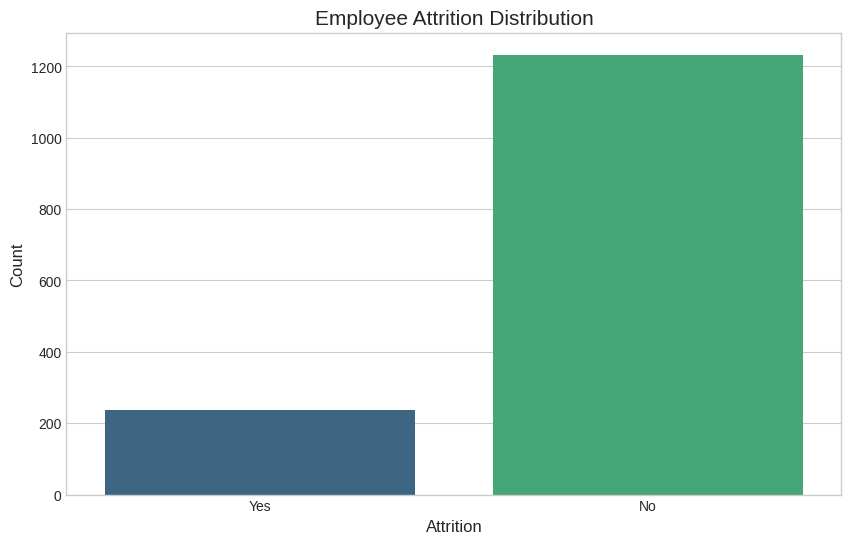

In [ ]:
# Visualize the target class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Attrition', data=df, palette='viridis')
plt.title('Employee Attrition Distribution', fontsize=15)
plt.xlabel('Attrition', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# Check unique values for categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:")
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"{col}: {unique_values} (Count: {len(unique_values)})")

Categorical columns:
Attrition: ['Yes' 'No'] (Count: 2)
BusinessTravel: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel'] (Count: 3)
Department: ['Sales' 'Research & Development' 'Human Resources'] (Count: 3)
EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources'] (Count: 6)
Gender: ['Female' 'Male'] (Count: 2)
JobRole: ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources'] (Count: 9)
MaritalStatus: ['Single' 'Married' 'Divorced'] (Count: 3)
Over18: ['Y'] (Count: 1)
OverTime: ['Yes' 'No'] (Count: 2)


In [ ]:
# Summary statistics for numerical features
numeric_summary = df.describe()
numeric_summary


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


## 3. Exploratory Data Analysis (EDA)

### Feature Analysis Based on Attrition
Let's examine key factors that might influence employee attrition by comparing the distributions of various features between employees who left and those who stayed.

In [ ]:
# Create a function to plot histograms by attrition status
def plot_histogram_by_attrition(feature):
  plt.figure(figsize=(12, 6))

  # Plot histograms for both attrition groups
  sns.histplot(data=df, x=feature, hue='Attrition', multiple='dodge',
                 palette={'Yes': '#FF5733', 'No': '#33A8FF'}, alpha=0.7, bins=20)

  plt.title(f'Distribution of {feature} by Attrition Status', fontsize=15)
  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Count', fontsize=12)
  plt.legend(title='Attrition')
  plt.tight_layout()
  plt.show()

  # Calculate and display group statistics
  group_stats = df.groupby('Attrition')[feature].agg(['mean', 'median', 'std'])
  print(f"{feature} statistics by attrition group:")
  print(group_stats)
  print("\n")

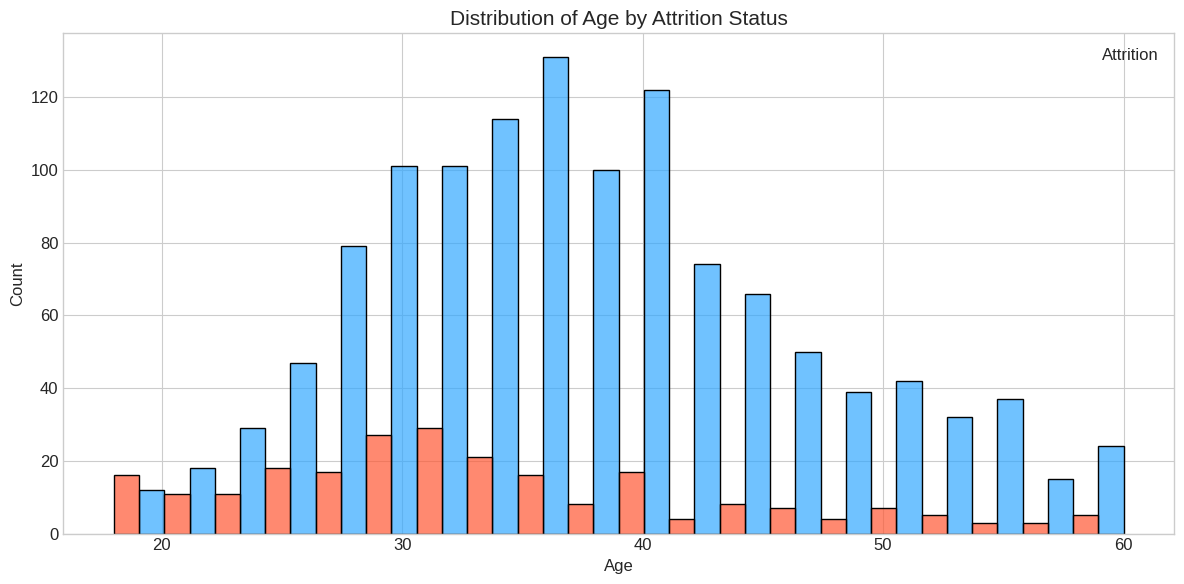

Age statistics by attrition group:
                mean  median      std
Attrition                            
No         37.561233    36.0  8.88836
Yes        33.607595    32.0  9.68935




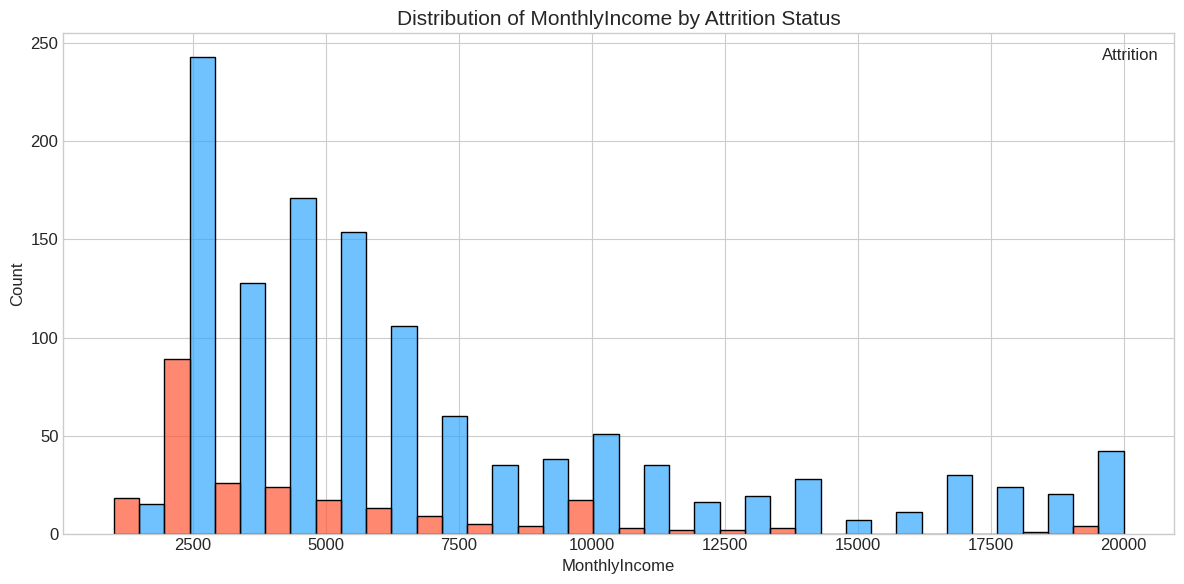

MonthlyIncome statistics by attrition group:
                  mean  median          std
Attrition                                  
No         6832.739659  5204.0  4818.208001
Yes        4787.092827  3202.0  3640.210367




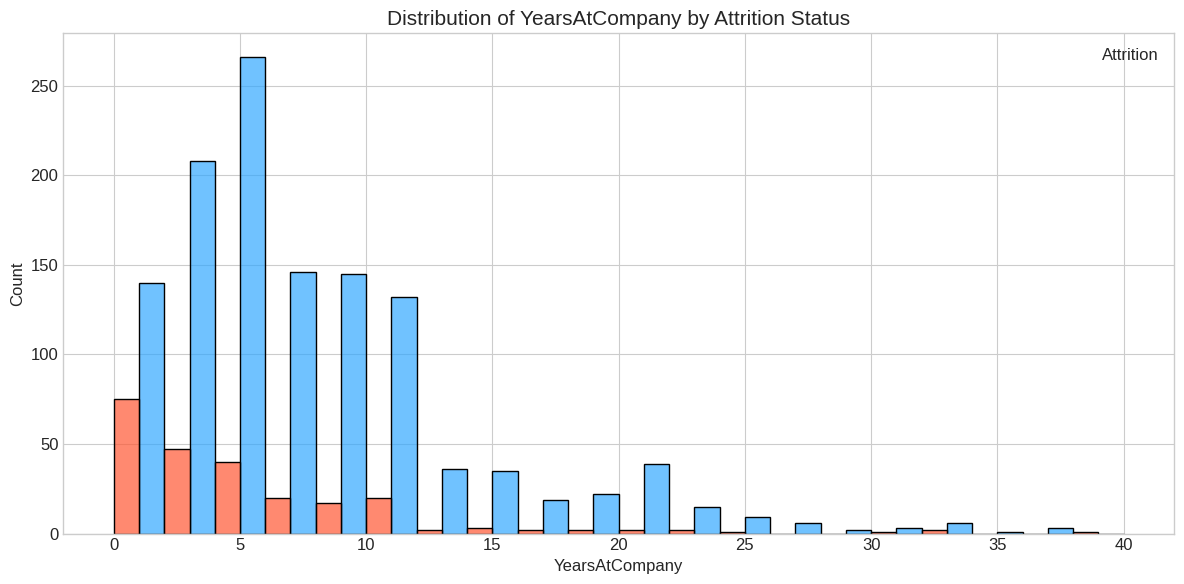

YearsAtCompany statistics by attrition group:
               mean  median       std
Attrition                            
No         7.369019     6.0  6.096298
Yes        5.130802     3.0  5.949984




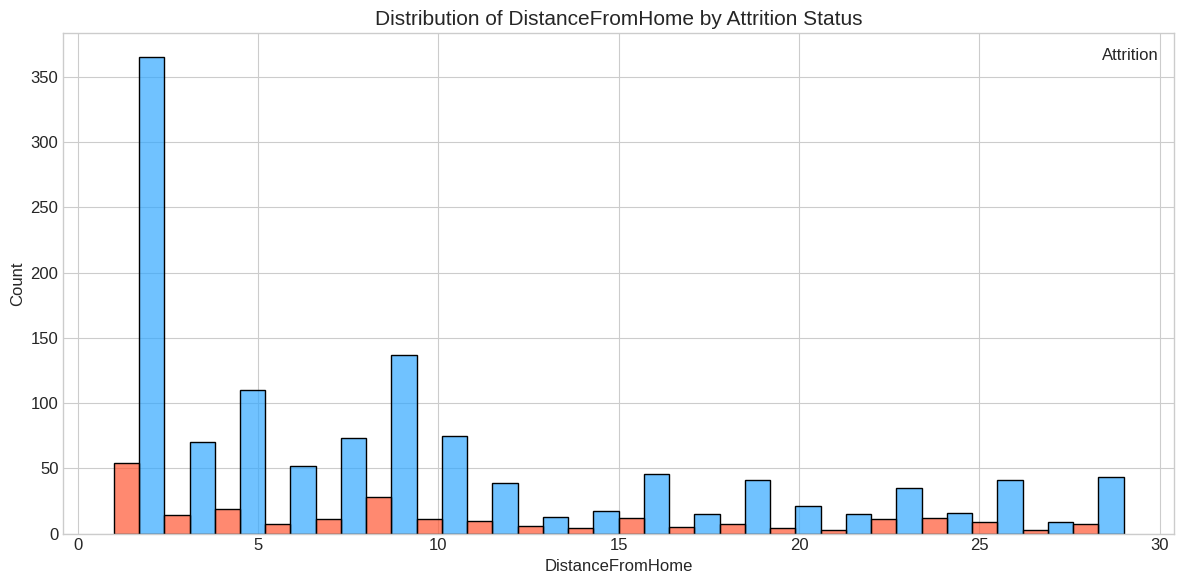

DistanceFromHome statistics by attrition group:
                mean  median       std
Attrition                             
No          8.915653     7.0  8.012633
Yes        10.632911     9.0  8.452525




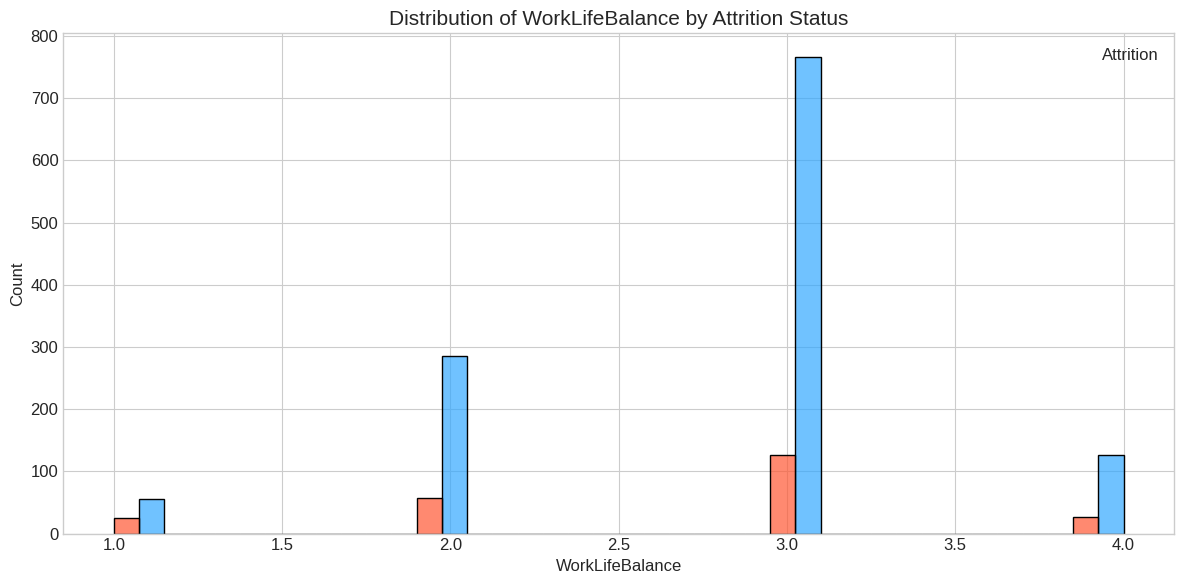

WorkLifeBalance statistics by attrition group:
               mean  median       std
Attrition                            
No         2.781022     3.0  0.681907
Yes        2.658228     3.0  0.816453




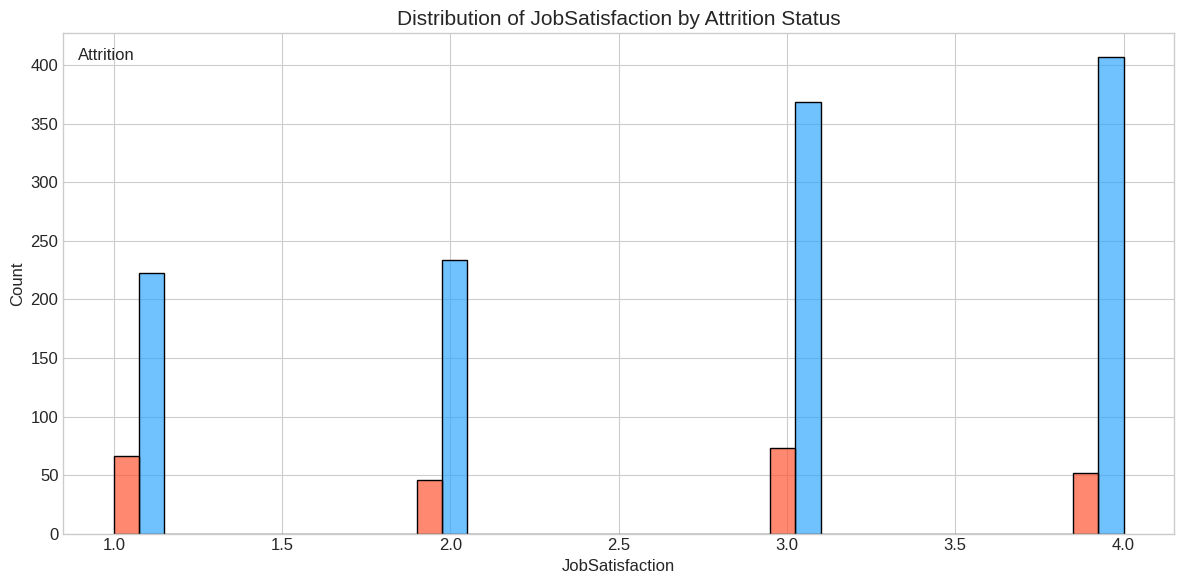

JobSatisfaction statistics by attrition group:
               mean  median       std
Attrition                            
No         2.778589     3.0  1.093277
Yes        2.468354     3.0  1.118058




In [ ]:
# Analyze key numeric features
key_numeric_features = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'DistanceFromHome','WorkLifeBalance', 'JobSatisfaction']

for feature in key_numeric_features:
  plot_histogram_by_attrition(feature)

###Observation

**1.Distribution of Age by Attrition Status**

As seen in the chart above, the attrition is maximum between the age groups 28-32. The attrition rate keeps on falling with increasing age, as people look after stability in their jobs at these point of times. Also at a very younger age, i.e. from 18-20, the chances of an employee leaving the organization is far more- since they are exploring at that point of time. It reaches a break even point at the age of 21

**2.Distribution of MonthlyIncome by Attrition Status**

As seen in the above chart, the attrition rate is evidently high at very low income levels- less than 5k monthly. This decreases further- but a minor spike is noticed aorund 10k- indicating the middle class liveliood. They tend to shift towards a better standard of living, and hence move to a different job. When the monthly income is pretty decent, the chances of an employee leaving the organization is low- as seen by the flat line


**3.Distribution of YearsAtCompany by Attrition Status**

We have seen people are more prone to leave the organization in the starting years on their role. When people are in the same role for a long period of time, they tend to stay longer for moving in an upward role.


**4.Distribution of DistanceFromHome by Attrition Status**

Employees who live further away from work might have higher attrition due to commute-related stress or seeking jobs closer to home.

**5.Distribution of WorkLifeBalance by Attrition Status**

Employees with lower work-life balance ratings are likely to have higher attrition due to burnout or seeking a better work-life integration.
As work-life balance improves, attrition might decrease.

**6.Distribution of WorkLifeBalance by Attrition Status**

Employees with lower job satisfaction are likely to have higher attrition as they seek more fulfilling roles.Attrition might decrease as job satisfaction increases.It's important to consider other factors that contribute to job satisfaction, like work environment, recognition, and growth opportunities.


In [ ]:
# Function to plot categorical variables

def plot_categorical_by_attrition(feature):
  plt.figure(figsize=(12, 6))

  # Calculate attrition rate for each category
  attrition_rate = df.groupby(feature)['Attrition'].apply(lambda x: (x == 'Yes').mean() * 100).sort_values(ascending=False)
  # Plot the counts with split by attrition
  ax = sns.countplot(x=feature, hue='Attrition', data=df,
                     palette={'Yes': '#FF5733', 'No': '#33A8FF'}, alpha=0.8)

  plt.title(f'Count and Attrition Rate by {feature}', fontsize=15)
  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Count', fontsize=12)
  plt.xticks(rotation=45, ha='right')
  plt.legend(title='Attrition')

  # Add attrition rate as text labels at the top of each bar group # Moved this block of code inside the function
  x_positions = {}
  for i, category in enumerate(df[feature].unique()):
    x_positions[category] = i

  for category, rate in attrition_rate.items():
    plt.text(x_positions[category], df[feature].value_counts()[category] + 10,f'{rate:.1f}%', ha='center', fontsize=10, color='black')

  plt.tight_layout()
  plt.show()

  # Display attrition rate table
  category_counts = df[feature].value_counts().reset_index()
  category_counts.columns = [feature, 'Count']
  attrition_rate_df = attrition_rate.reset_index()
  attrition_rate_df.columns = [feature, 'Attrition Rate (%)']
  summary_df = pd.merge(category_counts, attrition_rate_df, on=feature)
  print(f"Attrition rate by {feature}:")
  print(summary_df)

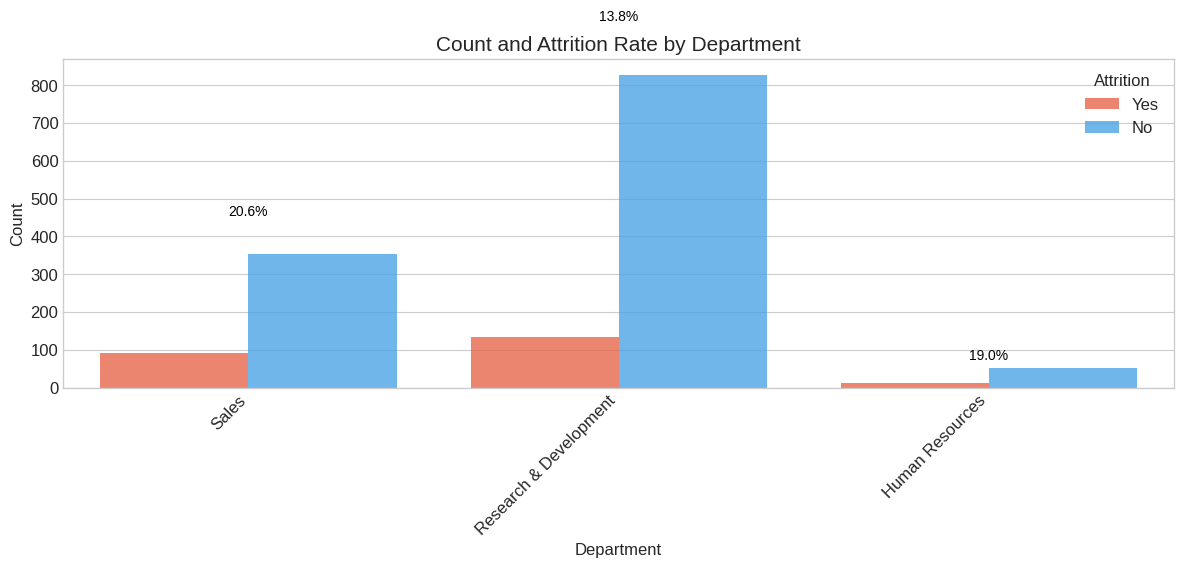

Attrition rate by Department:
               Department  Count  Attrition Rate (%)
0  Research & Development    961           13.839750
1                   Sales    446           20.627803
2         Human Resources     63           19.047619


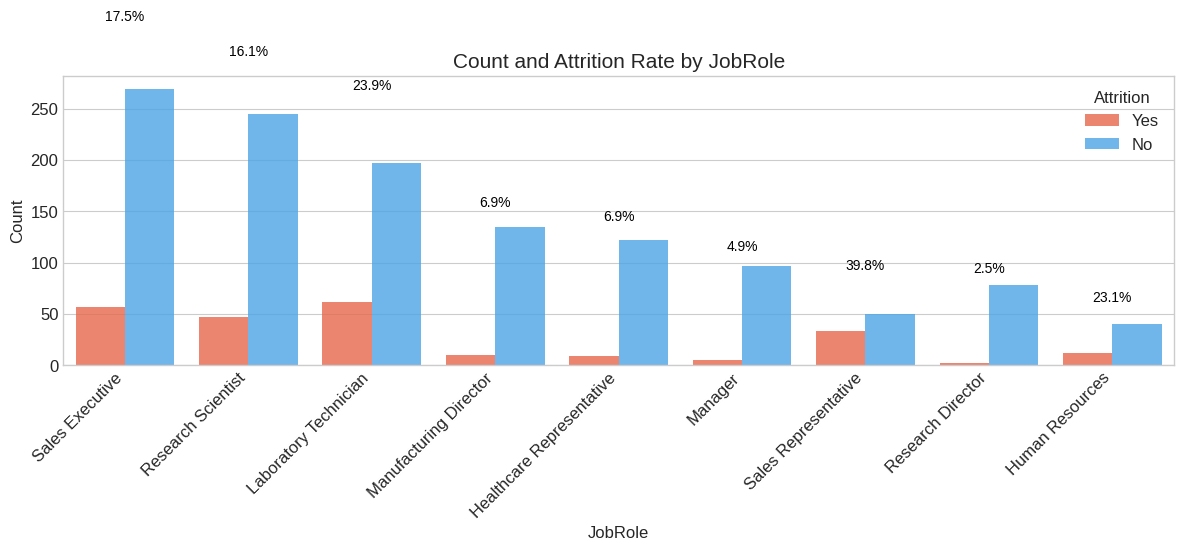

Attrition rate by JobRole:
                     JobRole  Count  Attrition Rate (%)
0            Sales Executive    326           17.484663
1         Research Scientist    292           16.095890
2      Laboratory Technician    259           23.938224
3     Manufacturing Director    145            6.896552
4  Healthcare Representative    131            6.870229
5                    Manager    102            4.901961
6       Sales Representative     83           39.759036
7          Research Director     80            2.500000
8            Human Resources     52           23.076923


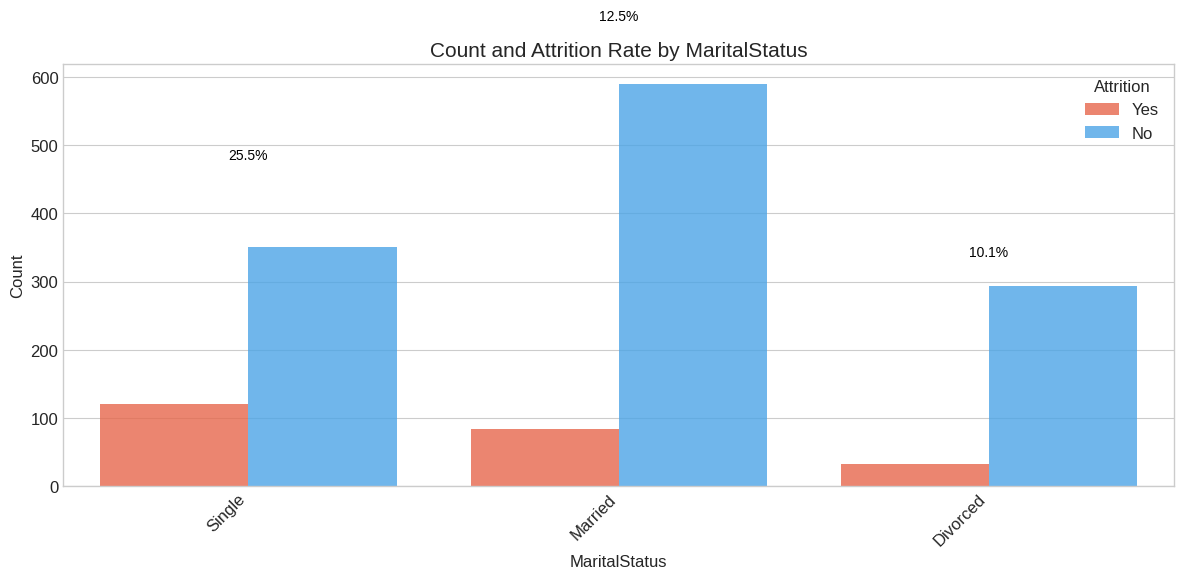

Attrition rate by MaritalStatus:
  MaritalStatus  Count  Attrition Rate (%)
0       Married    673           12.481426
1        Single    470           25.531915
2      Divorced    327           10.091743


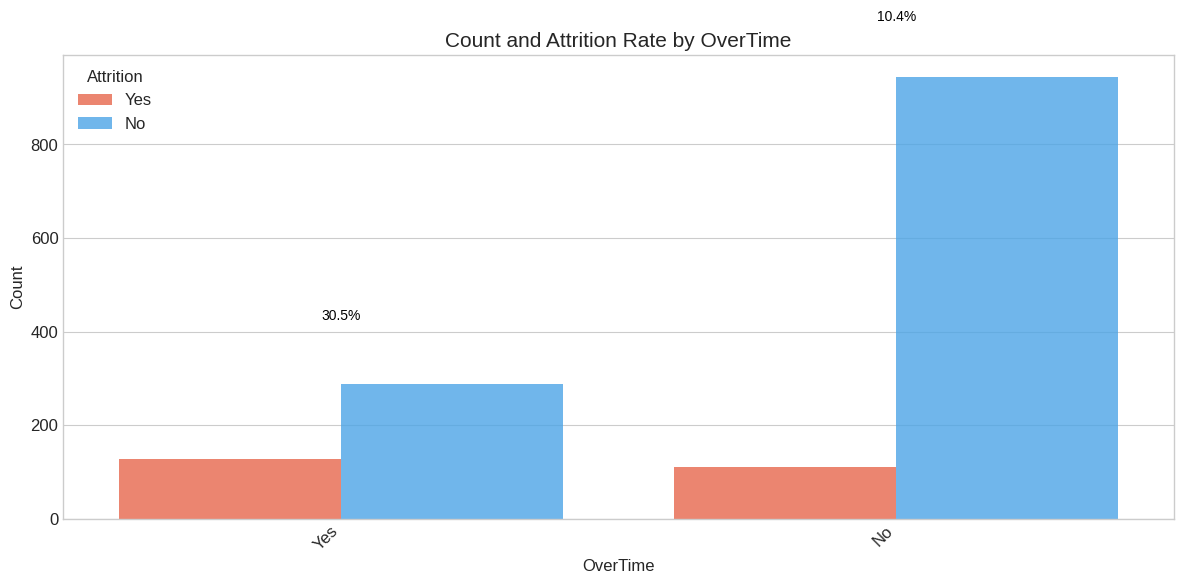

Attrition rate by OverTime:
  OverTime  Count  Attrition Rate (%)
0       No   1054           10.436433
1      Yes    416           30.528846


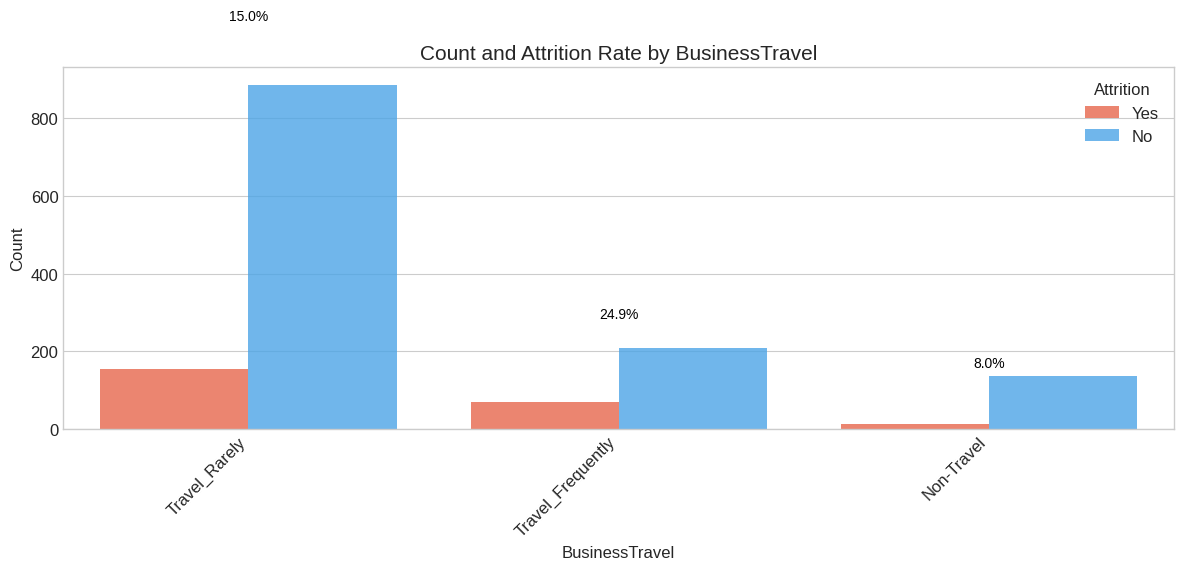

Attrition rate by BusinessTravel:
      BusinessTravel  Count  Attrition Rate (%)
0      Travel_Rarely   1043           14.956855
1  Travel_Frequently    277           24.909747
2         Non-Travel    150            8.000000


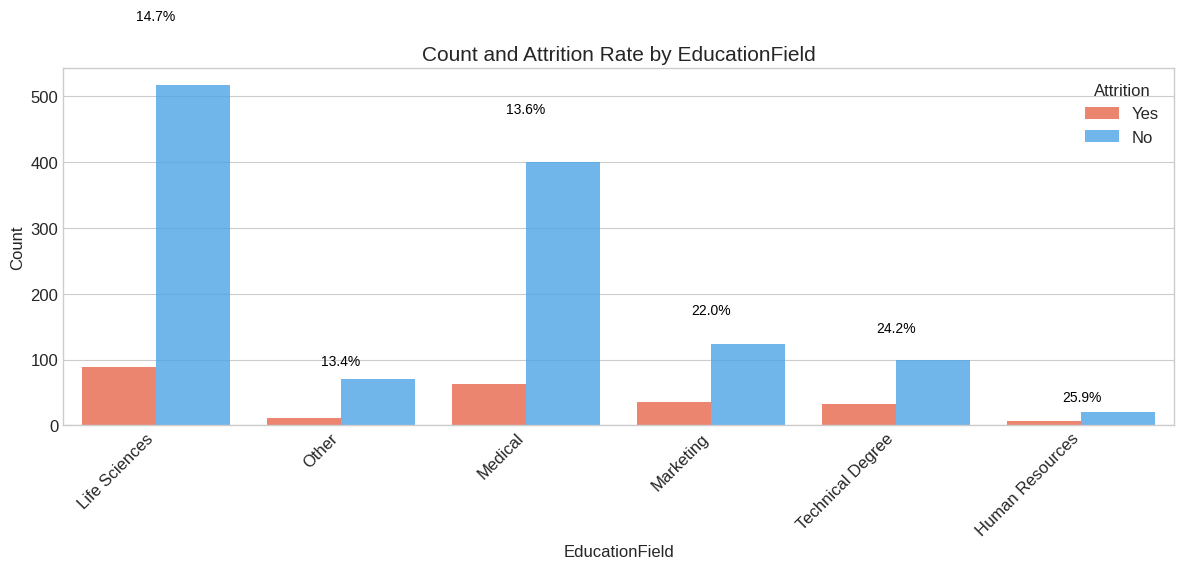

Attrition rate by EducationField:
     EducationField  Count  Attrition Rate (%)
0     Life Sciences    606           14.686469
1           Medical    464           13.577586
2         Marketing    159           22.012579
3  Technical Degree    132           24.242424
4             Other     82           13.414634
5   Human Resources     27           25.925926


In [ ]:
# Analyze key categorical features

key_categorical_features = ['Department', 'JobRole', 'MaritalStatus', 'OverTime', 'BusinessTravel', 'EducationField']

for feature in key_categorical_features:
  plot_categorical_by_attrition(feature)


###Correlation Analysis

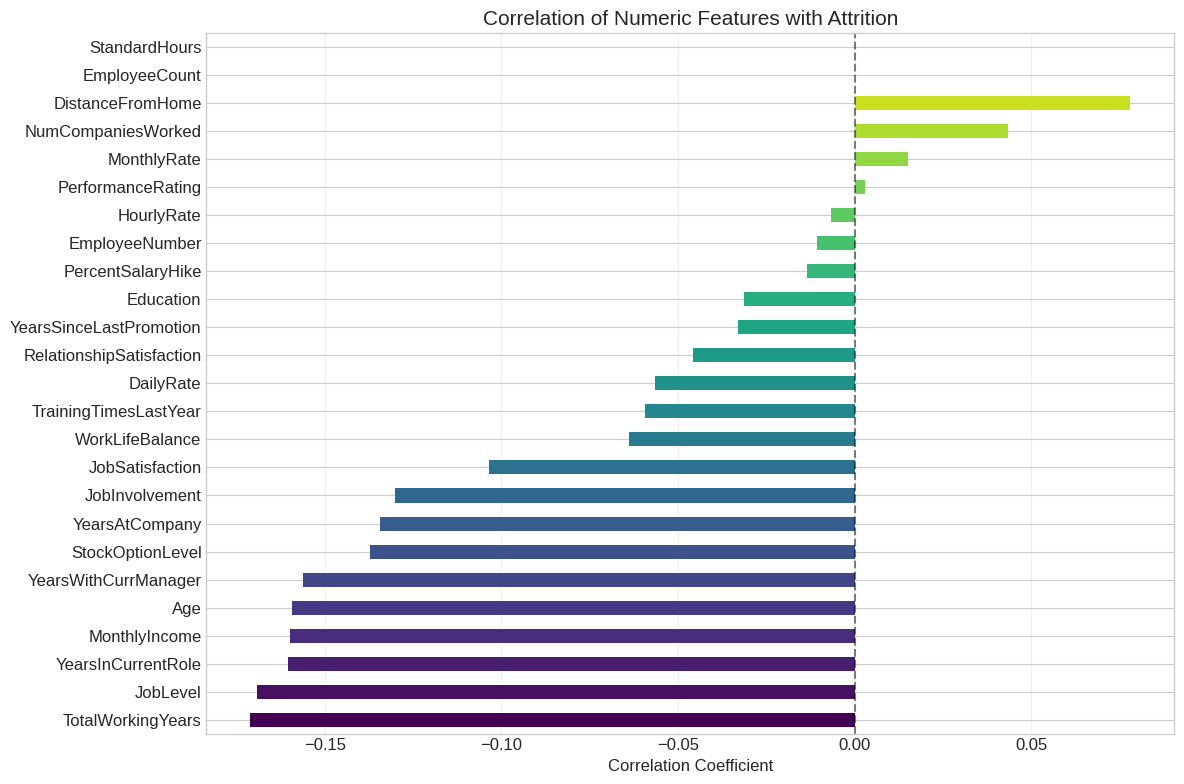

Feature correlations with Attrition:
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
EmployeeNumber             -0.010577
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
EmployeeCount                    NaN
StandardHours                    NaN
dtype: float64


In [ ]:
# Create a binary target variable for correlation analysis
df_corr = df.copy()
df_corr['AttritionBinary'] = df_corr['Attrition'].map({'Yes': 1, 'No': 0})

# Calculate correlations with numeric features
numeric_features = df_corr.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_with_attrition = df_corr[numeric_features].corrwith(df_corr['AttritionBinary']).sort_values(ascending=False)

# Plot correlations with attrition
plt.figure(figsize=(12, 8))
correlation_with_attrition.drop('AttritionBinary').sort_values().plot(kind='barh', color=plt.cm.viridis(np.linspace(0, 1, len(correlation_with_attrition)-1)))
plt.title('Correlation of Numeric Features with Attrition', fontsize=15)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# Display the correlation values
print("Feature correlations with Attrition:")
print(correlation_with_attrition.drop('AttritionBinary').sort_values(ascending=False))



### Feature Importance Analysis

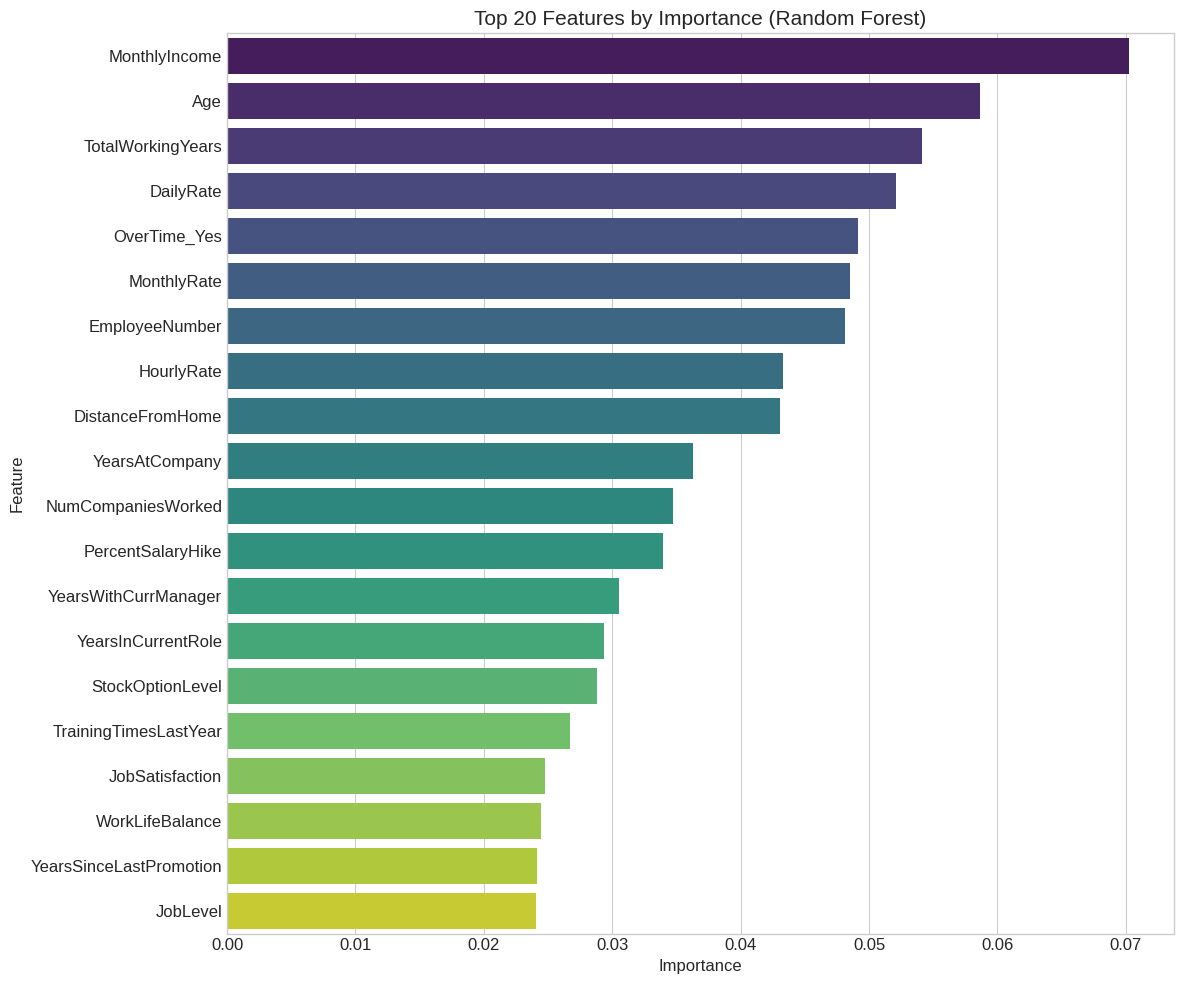

In [ ]:
# Create dummy variables for categorical features to identify their importance
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Prepare data for preliminary feature importance analysis
X = df_encoded.drop('Attrition_Yes', axis=1)
y = df_encoded['Attrition_Yes']

# Train a Random Forest model for feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({'Feature': X.columns,'Importance': rf_model.feature_importances_})
# Sort features by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

# Plot top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Features by Importance (Random Forest)', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

### Multivariate Analysis

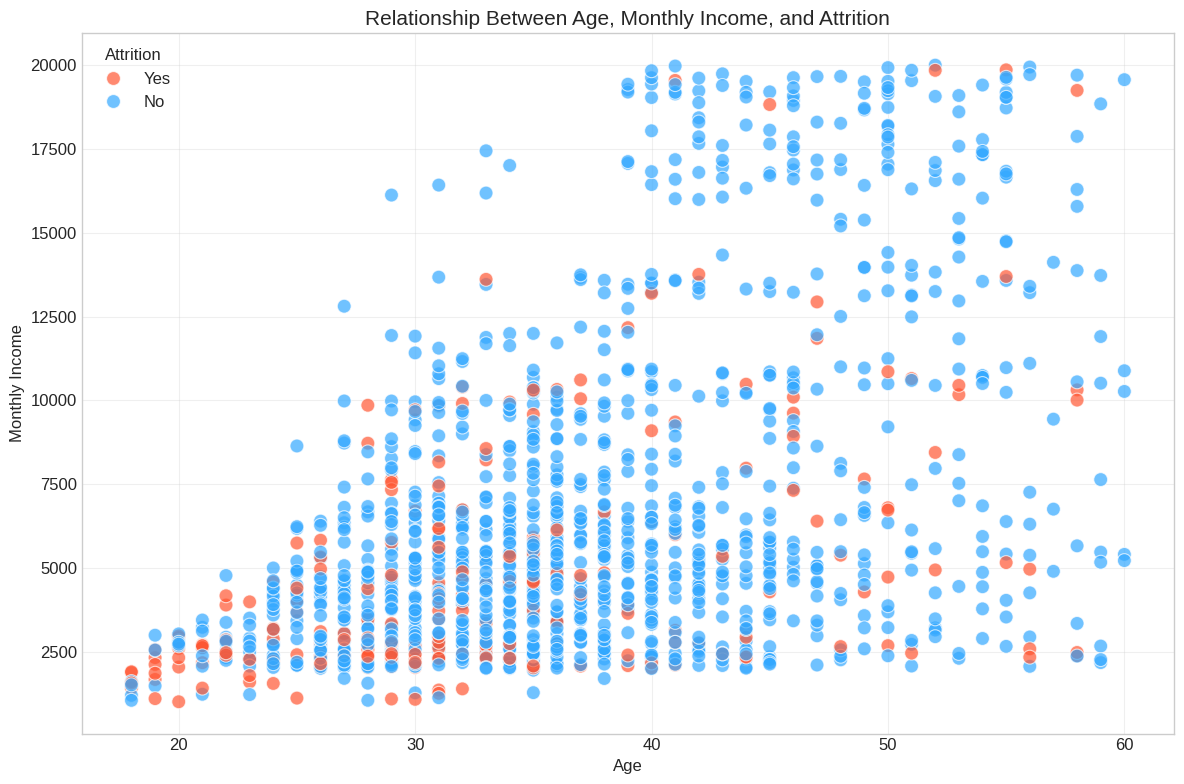

In [ ]:
# Plot relationship between age, monthly income, and attrition

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Age', y='MonthlyIncome', hue='Attrition', data=df, palette={'Yes': '#FF5733', 'No': '#33A8FF'}, alpha=0.7, s=100)
plt.title('Relationship Between Age, Monthly Income, and Attrition', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Monthly Income', fontsize=12)
plt.legend(title='Attrition')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## 4. Feature Engineering


In [ ]:
# Create a copy of the dataframe for feature engineering
df_fe = df.copy()

# 1. Remove redundant or constant features
# Check for columns with a single unique value
constant_columns = [col for col in df_fe.columns if df_fe[col].nunique() == 1]
print(f"Removing constant columns: {constant_columns}")
df_fe.drop(columns=constant_columns, inplace=True)

# 2. Target encoding (converting target to binary)
df_fe['Attrition'] = df_fe['Attrition'].map({'Yes': 1, 'No': 0})


Removing constant columns: ['EmployeeCount', 'Over18', 'StandardHours']


Categorical columns to encode: ['BusinessTravel', 'Department', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

Dataset shape after feature engineering: (1470, 53)
New features created: 18


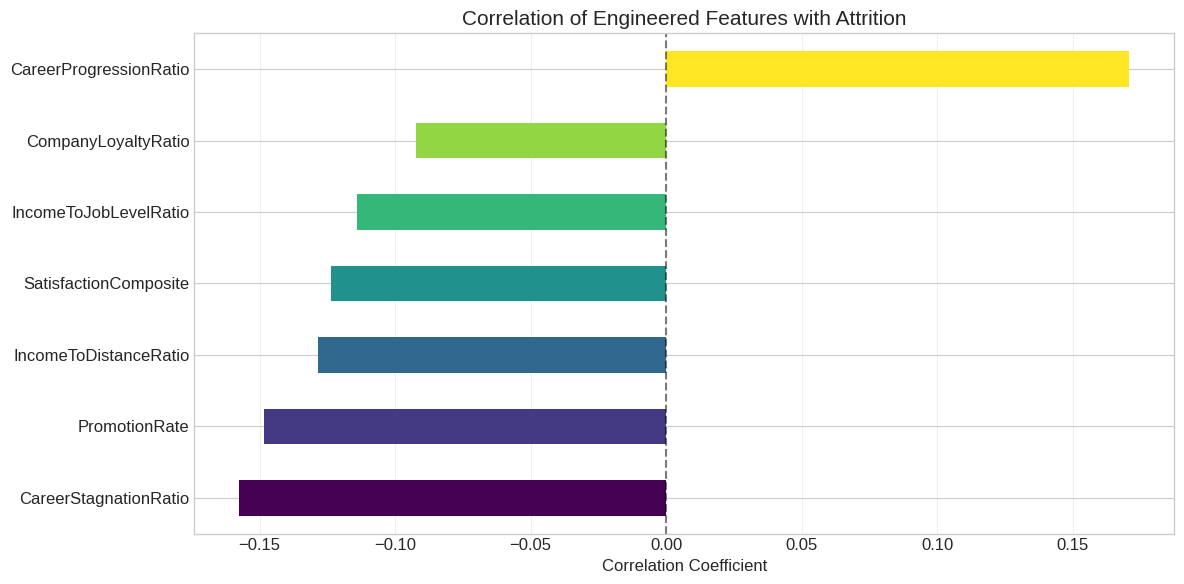

In [ ]:
# 3. Create interaction features based on our EDA findings

# Income relative to job level
df_fe['IncomeToJobLevelRatio'] = df_fe['MonthlyIncome'] / df_fe['JobLevel']

# Career progression ratio
df_fe['CareerProgressionRatio'] = df_fe['JobLevel'] / (df_fe['TotalWorkingYears'] + 1)

# Satisfaction composite score
satisfaction_columns = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'RelationshipSatisfaction']
df_fe['SatisfactionComposite'] = df_fe[satisfaction_columns].mean(axis=1)

# Company loyalty indicator (years at company relative to total working years)
df_fe['CompanyLoyaltyRatio'] = df_fe['YearsAtCompany'] / (df_fe['TotalWorkingYears'] + 1)

# Career stagnation indicator (Years in current role / Years at company)
df_fe['CareerStagnationRatio'] = df_fe['YearsInCurrentRole'] / (df_fe['YearsAtCompany'] + 1)

# Promotion frequency
df_fe['PromotionRate'] = (df_fe['YearsAtCompany'] - df_fe['YearsSinceLastPromotion']) / (df_fe['YearsAtCompany'] + 1)

# Income-to-distance compromise (income divided by distance)
df_fe['IncomeToDistanceRatio'] = df_fe['MonthlyIncome'] / (df_fe['DistanceFromHome'] + 1)

# 4. Binning age into categories
df_fe['AgeGroup'] = pd.cut(df_fe['Age'], bins=[18, 25, 35, 45, 60], labels=['18-25', '26-35', '36-45', '46-60'])

# 5. Encode categorical variables
# Identify categorical columns (excluding the target variable and the engineered 'SatisfactionComposite')
categorical_columns = df_fe.select_dtypes(include=['object']).columns.tolist()
# Remove 'SatisfactionComposite' if it's in the list to avoid encoding it
if 'SatisfactionComposite' in categorical_columns:
    categorical_columns.remove('SatisfactionComposite')

print(f"Categorical columns to encode: {categorical_columns}")

# Use one-hot encoding for categorical variables
df_fe_encoded = pd.get_dummies(df_fe, columns=categorical_columns, drop_first=True)

# Display the new features
print(f"\nDataset shape after feature engineering: {df_fe_encoded.shape}")
print(f"New features created: {df_fe_encoded.shape[1] - df.shape[1]}")

# Show the first few rows of the transformed dataset
df_fe_encoded.head()

# Check correlation of engineered features with attrition
engineered_features = ['IncomeToJobLevelRatio', 'CareerProgressionRatio', 'SatisfactionComposite', \
                         'CompanyLoyaltyRatio', 'CareerStagnationRatio', 'PromotionRate', 'IncomeToDistanceRatio']

correlation_with_attrition = df_fe_encoded[engineered_features + ['Attrition']].corr()['Attrition'].sort_values()

# Plot correlations of engineered features with attrition
plt.figure(figsize=(12, 6))
correlation_with_attrition.drop('Attrition').plot(kind='barh', color=plt.cm.viridis(np.linspace(0, 1, len(engineered_features))))
plt.title('Correlation of Engineered Features with Attrition', fontsize=15)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

##5. Model Development

In [ ]:
# Prepare the data for modeling\n",
X = df_fe_encoded.drop('Attrition', axis=1)
y = df_fe_encoded['Attrition']

if 'AgeGroup' in X.columns:
    X = X.drop('AgeGroup', axis=1)

In [ ]:
X = X.select_dtypes(exclude=['object', 'category'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:


# Define preprocessing pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])


In [ ]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
}

In [ ]:
# Store results for comparison
results = {}
cv_results = {}

In [ ]:
# Define evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Return results as a dictionary
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': auc_score,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }


In [ ]:
# Define cross-validation strategy (stratified k-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Train models and evaluate with cross-validation
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Scale the features
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate on test set
    results[name] = evaluate_model(model, X_test_scaled, y_test)

    # Perform cross-validation
    cv_scores = cross_val_score(model, preprocessor.transform(X), y, cv=cv, scoring='roc_auc')
    cv_results[name] = {
        'Mean ROC AUC': cv_scores.mean(),
        'Std Dev': cv_scores.std(),
        'CV Scores': cv_scores
    }

    print(f"Test ROC AUC: {results[name]['ROC AUC']:.4f}")
    print(f"Cross-Validation ROC AUC: {cv_results[name]['Mean ROC AUC']:.4f} (±{cv_results[name]['Std Dev']:.4f})")


Training Logistic Regression...
Test ROC AUC: 0.8028
Cross-Validation ROC AUC: 0.8160 (±0.0137)

Training Random Forest...
Test ROC AUC: 0.7473
Cross-Validation ROC AUC: 0.7860 (±0.0192)

Training XGBoost...
Test ROC AUC: 0.7335
Cross-Validation ROC AUC: 0.7832 (±0.0067)


In [ ]:
# Handling imbalanced data with SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE:
Attrition
0    924
1    924
Name: count, dtype: int64


In [ ]:
models_smote = {
    'Logistic Regression (SMOTE)': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest (SMOTE)': RandomForestClassifier(random_state=42),
    'XGBoost (SMOTE)': xgb.XGBClassifier(random_state=42)
}

In [ ]:
results_smote = {}

In [ ]:
for name, model in models_smote.items():
    print(f"Training {name}...")

    # Train the model on SMOTE-balanced data
    model.fit(X_train_smote, y_train_smote)

    # Evaluate on test set
    results_smote[name] = evaluate_model(model, X_test_scaled, y_test)

    print(f"Test ROC AUC: {results_smote[name]['ROC AUC']:.4f}")
    print(f"Recall (ability to detect attrition): {results_smote[name]['Recall']:.4f}")





Training Logistic Regression (SMOTE)...
Test ROC AUC: 0.8013
Recall (ability to detect attrition): 0.6780
Training Random Forest (SMOTE)...
Test ROC AUC: 0.7723
Recall (ability to detect attrition): 0.2542
Training XGBoost (SMOTE)...
Test ROC AUC: 0.7593
Recall (ability to detect attrition): 0.2881


In [ ]:
# Custom threshold tuning for better recall
best_model = models_smote['Logistic Regression (SMOTE)']  # Choose the best model based on previous results
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Try different thresholds and evaluate metrics
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_metrics = []

In [ ]:
for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    threshold_metrics.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

In [ ]:
# Convert to DataFrame for easier analysis
threshold_df = pd.DataFrame(threshold_metrics)

In [ ]:
# Find the threshold that maximizes F1 score
best_f1_idx = threshold_df['F1 Score'].idxmax()
best_f1_threshold = threshold_df.loc[best_f1_idx, 'Threshold']
print(f"Best threshold for maximizing F1 score: {best_f1_threshold:.2f}")
print(f"Metrics at this threshold: ")
print(f"  Accuracy: {threshold_df.loc[best_f1_idx, 'Accuracy']:.4f}")
print(f"  Precision: {threshold_df.loc[best_f1_idx, 'Precision']:.4f}")
print(f"  Recall: {threshold_df.loc[best_f1_idx, 'Recall']:.4f}")
print(f"  F1 Score: {threshold_df.loc[best_f1_idx, 'F1 Score']:.4f}")

Best threshold for maximizing F1 score: 0.60
Metrics at this threshold: 
  Accuracy: 0.8261
  Precision: 0.4675
  Recall: 0.6102
  F1 Score: 0.5294


In [ ]:
from sklearn.metrics import confusion_matrix
# Predict using the best threshold
y_pred_best_threshold = (y_pred_proba >= best_f1_threshold).astype(int)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best_threshold)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[268  41]
 [ 23  36]]


In [ ]:
# Function for making predictions with the best model and optimized threshold
def predict_attrition(employee_data, model=best_model, preprocessor=preprocessor, threshold=best_f1_threshold):
    """
    Predict attrition probability for a given employee or dataset

    Parameters:
    -----------
    employee_data : pandas DataFrame
        Employee data with the same features as the training data
    model : trained model
        The best model for prediction
    preprocessor : sklearn preprocessor
        The preprocessor used to scale features
    threshold : float
        The optimal threshold for classification

    Returns:
    --------
    Dictionary with prediction results:
    - prediction: Binary prediction (0=No, 1=Yes)
    - probability: Probability of attrition
    - risk_level: Risk category (Low, Medium, High)
    """
    # Scale the features
    X_scaled = preprocessor.transform(employee_data)

    # Get probability prediction
    attrition_prob = model.predict_proba(X_scaled)[:, 1]

    # Apply the optimal threshold
    prediction = (attrition_prob >= threshold).astype(int)

    # Assign risk levels
    risk_levels = []
    for prob in attrition_prob:
        if prob < 0.3:
            risk_levels.append('Low')
        elif prob < 0.7:
            risk_levels.append('Medium')
        else:
            risk_levels.append('High')

    # Return results
    return {
        'prediction': prediction,
        'probability': attrition_prob,
        'risk_level': risk_levels
    }

# Example of using the prediction function (with test data)
sample_prediction = predict_attrition(X_test[:5])
print("\nSample predictions for 5 test employees:")
for i in range(5):
    print(f"Employee {i+1}: Prediction={sample_prediction['prediction'][i]}, "
          f"Probability={sample_prediction['probability'][i]:.4f}, "
          f"Risk Level={sample_prediction['risk_level'][i]}")


Sample predictions for 5 test employees:
Employee 1: Prediction=0, Probability=0.0449, Risk Level=Low
Employee 2: Prediction=0, Probability=0.0140, Risk Level=Low
Employee 3: Prediction=0, Probability=0.2252, Risk Level=Low
Employee 4: Prediction=0, Probability=0.1247, Risk Level=Low
Employee 5: Prediction=1, Probability=0.6624, Risk Level=Medium
